In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sklearn as sk
import pandas as pd

sys.path.append('../../Classes')
from DataHandler import DataHandler
from NNModelTrainer import NNModelTrainer
from NNModelTester import NNModelTester

## Photometry

### Data + Model training + Tests

In [2]:
data = DataHandler(validation_sample= True, features_txt= 'all_features.txt', fields_list=['W02', 'W03', 'W04'], balance= 'weights')
data.main()

Members: 202787 (32.69%)
Non members: 417621 (67.31%)
----------------------------------------------------------------------
Training: 141951 members, 292334 non members
Validation: 42585 members, 87701 non members
Testing: 18251 members, 37586 non members
----------------------------------------------------------------------


In [3]:
layers_s_dropout = [
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ]

compile_params = dict(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics=[]   
    )

mod = NNModelTrainer(layers= layers_s_dropout, name= 'model_6', data= data, compile_params= compile_params)
# mod.train_model()
mod.load_model() # if model is already trained

In [4]:
test = NNModelTester(model= mod.model, data= data, name= 'model_6', history= mod.history)
test.predict()
test.curves()
test.write_report(extra_args= mod.args(), to_file = False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 61)               123       
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                3968      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                      

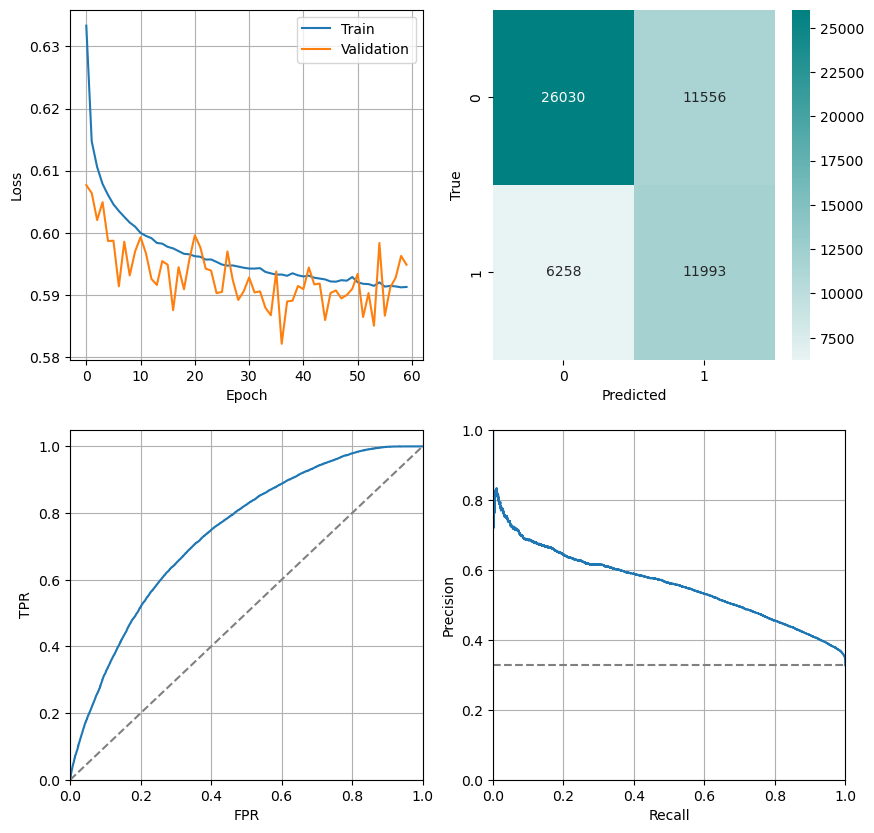

In [5]:
test.plot_report(to_file = False)

### Redshift distribution vs classification

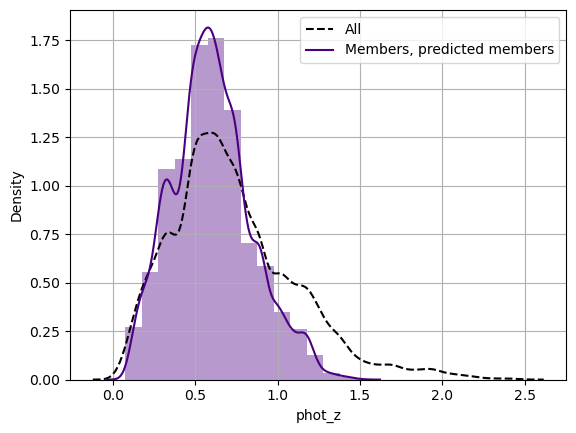

In [25]:
# true members, predicted as members
mm = data.testing[(data.testing['member'] == 1) & (data.testing['member'] == test.predictions.flatten())]
sns.histplot(data = mm, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = mm, x = 'phot_z', label = 'Members, predicted members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()


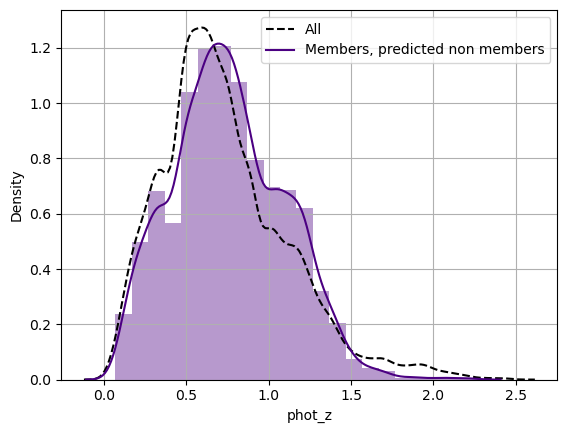

In [26]:
# true members, predicted as non members
mn = data.testing[(data.testing['member'] == 1) & (data.testing['member'] != test.predictions.flatten())]
sns.histplot(data = mn, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = mn, x = 'phot_z', label = 'Members, predicted non members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()

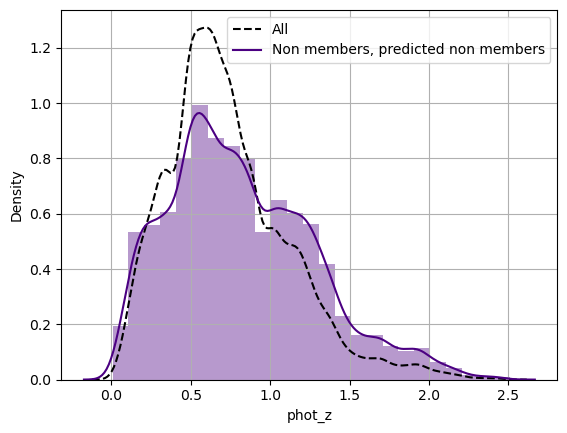

In [28]:
# true non members, predicted as non members
nn = data.testing[(data.testing['member'] == 0) & (data.testing['member'] == test.predictions.flatten())]
sns.histplot(data = nn, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = nn, x = 'phot_z', label = 'Non members, predicted non members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()


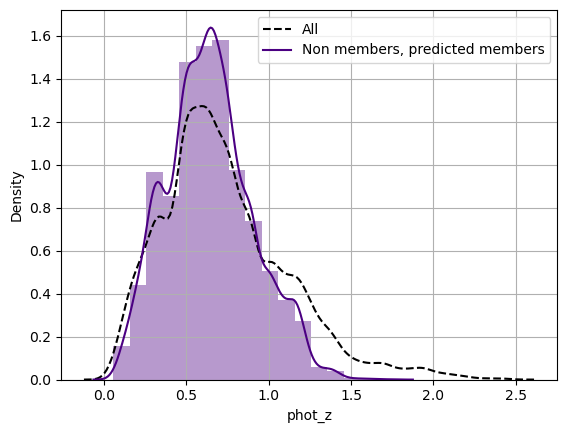

In [31]:
# true non members, predicted as members
nm = data.testing[(data.testing['member'] == 0) & (data.testing['member'] != test.predictions.flatten())]
sns.histplot(data = nm, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = nm, x = 'phot_z', label = 'Non members, predicted members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()


### Fraction of correct/incorrect classification vs redshift

In [61]:
# true members, predicted as members
mm = data.testing[(data.testing['member'] == 1) & (data.testing['member'] == test.predictions.flatten())]
# true members, predicted as non members
mn = data.testing[(data.testing['member'] == 1) & (data.testing['member'] != test.predictions.flatten())]
# members
m = data.testing[(data.testing['member'] == 1)]

# true non members, predicted as non members
nn = data.testing[(data.testing['member'] == 0) & (data.testing['member'] == test.predictions.flatten())]
# true non members, predicted as members
nm = data.testing[(data.testing['member'] == 0) & (data.testing['member'] != test.predictions.flatten())]
# non members
n = data.testing[(data.testing['member'] == 0)]

In [86]:
# divide in bins of redshift, and get the fraction of members correctly and incorrectly classifies in each bin
corr_mem = []
incorr_mem = []
mem = []
corr_non = []
incorr_non = []
non = []

z_lims = np.linspace(0.0,1.8,10)
step = 0.2

df_list = [mm,mn,m,nn,nm,n]
count_list = [corr_mem, incorr_mem, mem, corr_non, incorr_non, non]

for i in z_lims:
    for df,count in zip(df_list, count_list):
        zbin = df[(df.phot_z >= i) & (df.phot_z < i+step)]
        count.append(zbin.shape[0] )

corr_mem = np.array(corr_mem)
incorr_mem = np.array(incorr_mem)
mem = np.array(mem)
corr_non = np.array(corr_non)
incorr_non = np.array(incorr_non)
non = np.array(non)

names = [f'[{i :.1f};{i+step :.1f}]' for  i in z_lims]


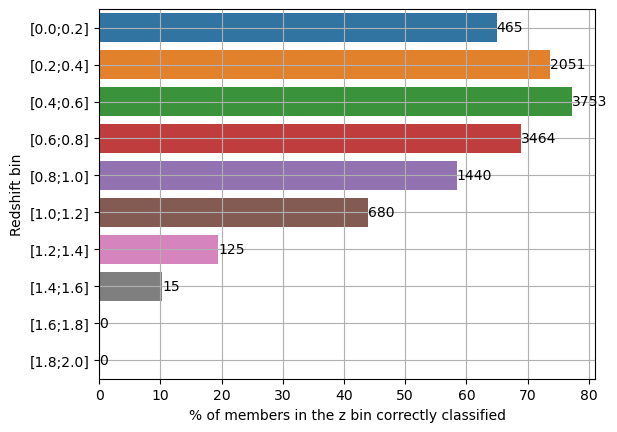

In [87]:
ax = sns.barplot(x = corr_mem/mem * 100, y = names, orient= 'h')
plt.xlabel('% of members in the z bin correctly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=corr_mem)
plt.show()

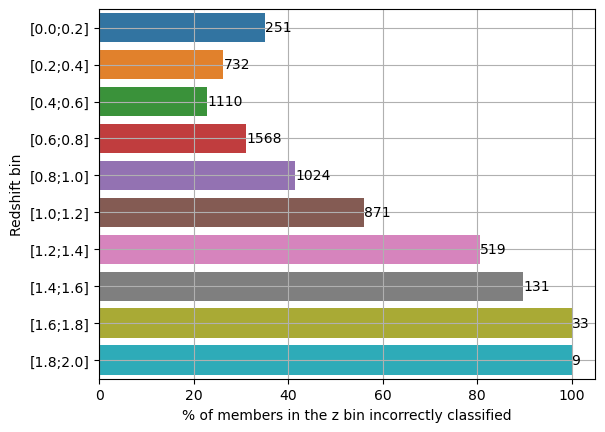

In [88]:
ax = sns.barplot(x = incorr_mem/mem*100, y = names, orient= 'h')
plt.xlabel('% of members in the z bin incorrectly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=incorr_mem)
plt.show()


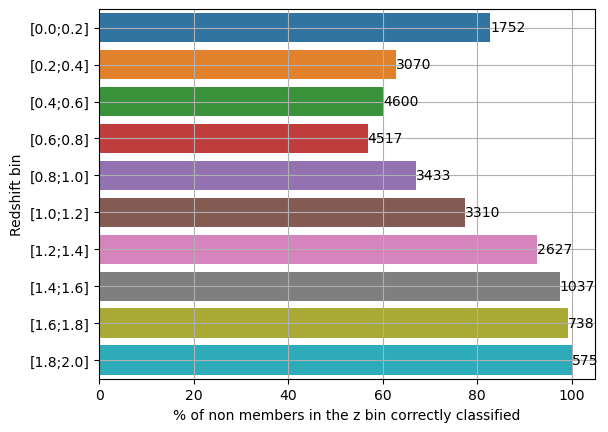

In [89]:
ax = sns.barplot(x = corr_non/non*100, y = names, orient= 'h')
plt.xlabel('% of non members in the z bin correctly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=corr_non)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

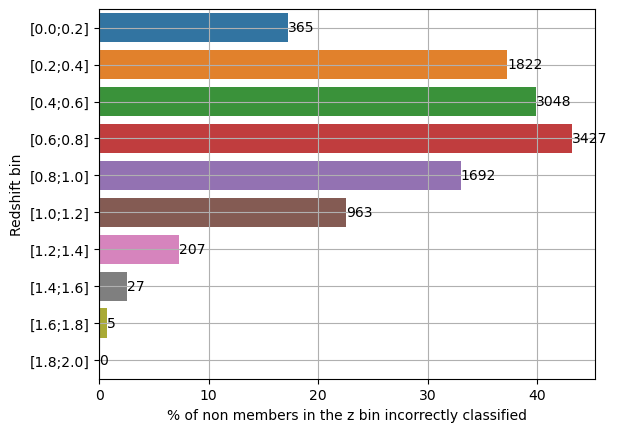

In [90]:
ax = sns.barplot(x = incorr_non/non*100, y = names, orient= 'h')
plt.xlabel('% of non members in the z bin incorrectly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=incorr_non)
plt.show

### Metrics vs redshift

In [6]:
min_ = 0.
max_ = 2.
step = 0.2
n_bins = int((max_ - min_)/step)
z_centers = np.linspace(min_ + step/2., max_ - step/2., n_bins)
z_lims = np.linspace(min_, max_, n_bins + 1)

print(z_centers)
print(z_lims)

[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


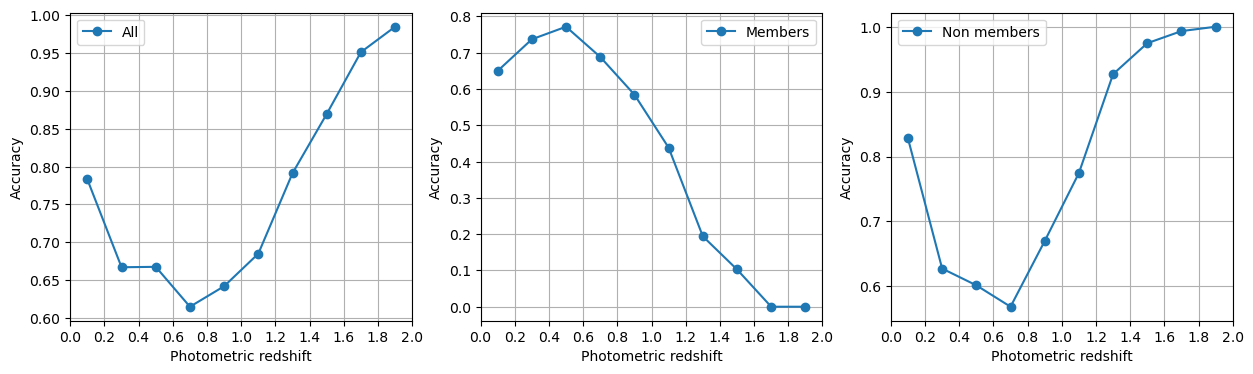

In [48]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
metric = sk.metrics.accuracy_score
met, met_mem, met_non = ([] for i in range(3))
for z in z_centers:
    cond = (data.testing['phot_z'] > z - step/2.) & (data.testing['phot_z'] <= z + step/2.)
    met.append(metric(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    cond = (data.testing['phot_z'] > z - step/2.) & (data.testing['phot_z'] <= z + step/2.) & (data.testing['member'] == 1)
    met_mem.append(metric(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    cond = (data.testing['phot_z'] > z - step/2.) & (data.testing['phot_z'] <= z + step/2.) & (data.testing['member'] == 0)
    met_non.append(metric(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

plt.figure(figsize=(15,4))
labels = ['All', 'Members', 'Non members']
for i,(a,l) in enumerate(zip([met, met_mem, met_non], labels)):
    plt.subplot(1,3,i+1)
    plt.plot(z_centers, a, label = l, marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Photometric redshift')
    plt.ylabel('Accuracy')
    plt.xticks(z_lims)
plt.show()

c:\Users\Gimena\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


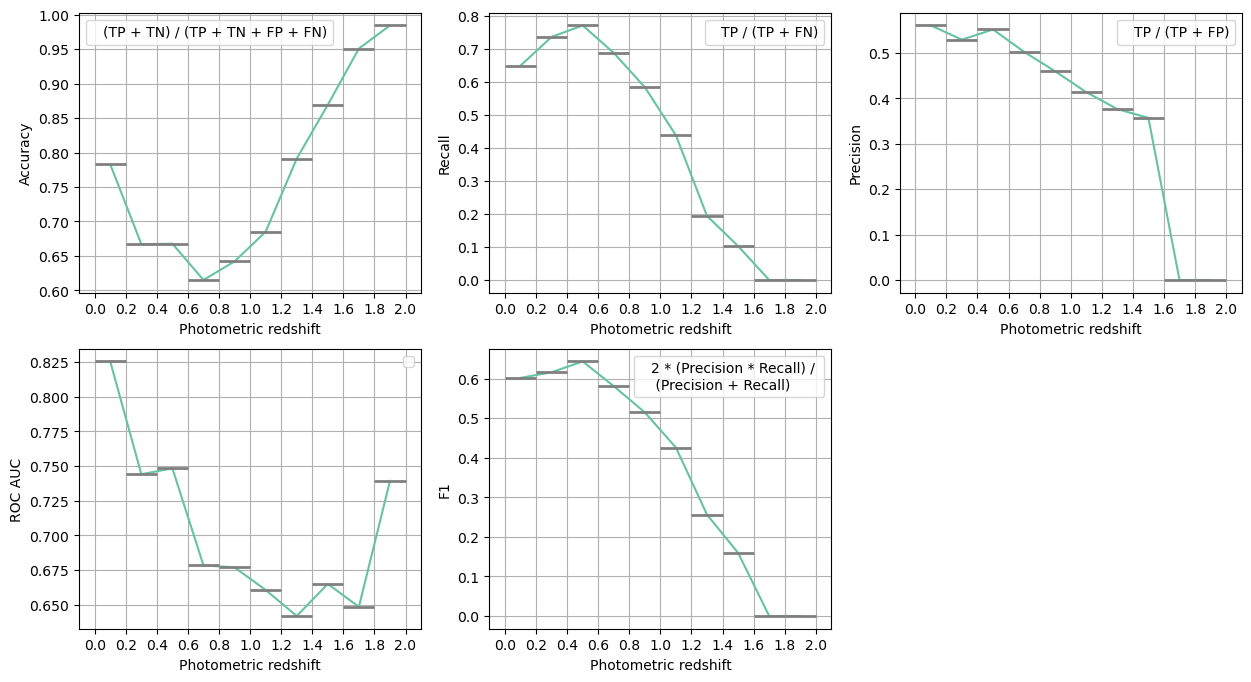

In [18]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
metrics = [sk.metrics.accuracy_score, sk.metrics.recall_score, sk.metrics.precision_score, sk.metrics.roc_auc_score, sk.metrics.f1_score]
names = ['Accuracy', 'Recall', 'Precision', 'ROC AUC', 'F1']
defs = [
    '(TP + TN) / (TP + TN + FP + FN)',
    'TP / (TP + FN)',
    'TP / (TP + FP)',
    '',
    '2 * (Precision * Recall) / \n (Precision + Recall)'
]

plt.figure(figsize=(15,8))
z_metrics = [[] for i in metrics]

for i,(met,zmet,nam,d) in enumerate(zip(metrics, z_metrics, names, defs)):
    for z in z_centers:
        cond = (data.testing['phot_z'] > z - step/2) & (data.testing['phot_z'] <= z + step/2)
        if nam == 'ROC AUC':
            zmet.append(met(y_true= data.testing_labels()[cond], y_score= test.scores[cond]))
        else:
            zmet.append(met(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    plt.subplot(2,3,i+1)
    plt.plot(z_centers, zmet, label = d)
    plt.grid()
    plt.xlabel('Photometric redshift')
    plt.ylabel(nam)
    plt.legend(markerscale=0, handlelength=0)
    plt.xticks(z_lims)

    for i, z in enumerate(z_centers):
        plt.hlines(zmet[i], z - step/2, z + step/2, color='grey', linewidth=2)
plt.show()

In [10]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
metrics = [sk.metrics.recall_score, sk.metrics.precision_score, sk.metrics.roc_auc_score]
names = ['Recall (Completitud)', 'Precision (Pureza)', 'ROC AUC']
defs = [
    'TP / (TP + FN)',
    'TP / (TP + FP)',
    ''
]

plt.figure(figsize=(7.5,2.3), dpi = 500)
pal = sns.color_palette("Set2")
sns.set_palette(pal, color_codes=True)
z_metrics = [[] for i in metrics]

for i,(met,zmet,nam,d) in enumerate(zip(metrics, z_metrics, names, defs)):
    for z in z_centers:
        cond = (data.testing['phot_z'] > z - step/2) & (data.testing['phot_z'] <= z + step/2)
        if nam == 'ROC AUC':
            zmet.append(met(y_true= data.testing_labels()[cond], y_score= test.scores[cond]))
        else:
            zmet.append(met(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    plt.subplot(1,3,i+1, facecolor = (1, 1, 1, 0.6))
    plt.plot(z_centers, zmet, label = d, lw=4, c = 'black')
    plt.grid(ls = '--', alpha=0.25, c = 'black')
    plt.xlabel('Redshift fotométrico')
    plt.ylabel(nam)
    if d:
        legend = plt.legend(edgecolor=(0, 0, 0, 1.), markerscale=0, handlelength=0)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0))
    plt.xticks([0.4,0.8,1.2,1.6])
    # plt.axes(frame_on=False)
    sns.despine(left=True, bottom=True, right=True)

    # for i, z in enumerate(z_centers):
    #     plt.hlines(zmet[i], z - step/2, z + step/2, color='grey', linewidth=2)
plt.tight_layout()
plt.savefig('demo.png', facecolor=(1,1,1,0))
plt.close()


c:\Users\Gimena\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Photometry + density

### Data + Model training + Tests

In [2]:
data = DataHandler(validation_sample= True, features_txt= 'all_features_sigmas.txt', fields_list=['W03'], balance= 'weights')
data.main()

Members: 69796 (32.40%)
Non members: 145618 (67.60%)
----------------------------------------------------------------------
Training: 48857 members, 101932 non members
Validation: 14657 members, 30580 non members
Testing: 6282 members, 13106 non members
----------------------------------------------------------------------


In [3]:
mod = NNModelTrainer(name= 'all_features+sigmas', data= data)
mod.load_model()

In [4]:
test = NNModelTester(model= mod.model, data= data, name= 'all_features+sigmas', history= mod.history)
test.predict()
test.curves()
test.write_report(extra_args= mod.args(), to_file = False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense (Dense)               (None, 512)               41472     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                        

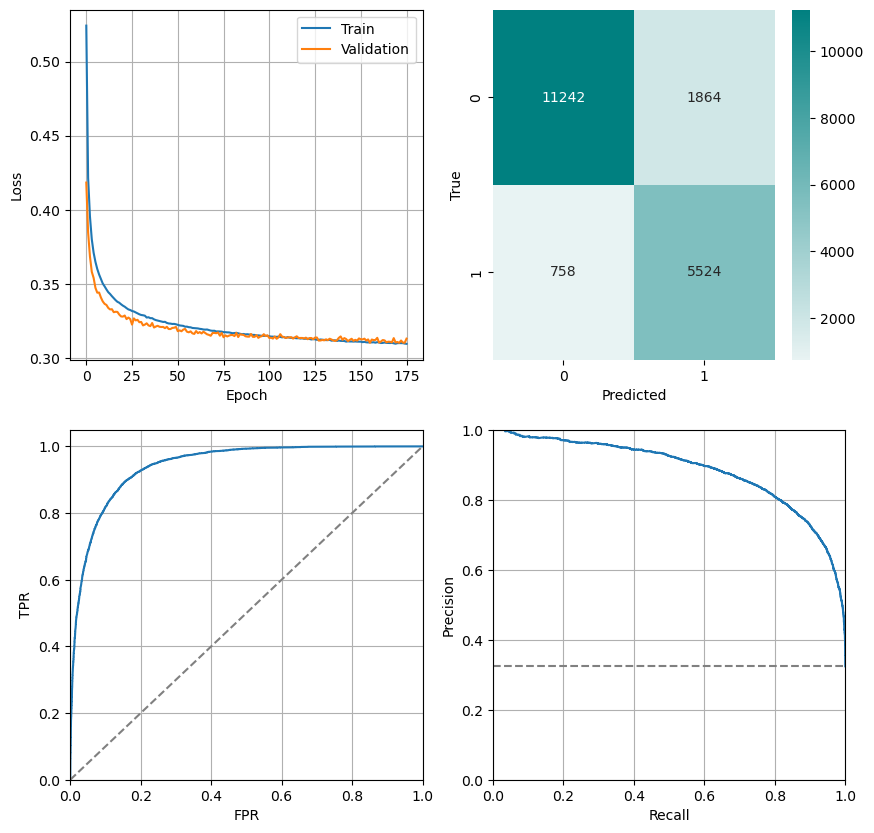

In [8]:
test.plot_report(to_file = False)

### Redshift distribution vs classification

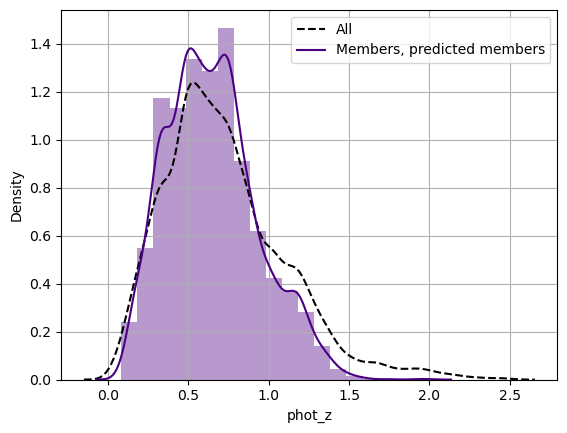

In [9]:
# true members, predicted as members
mm = data.testing[(data.testing['member'] == 1) & (data.testing['member'] == test.predictions.flatten())]
sns.histplot(data = mm, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = mm, x = 'phot_z', label = 'Members, predicted members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()


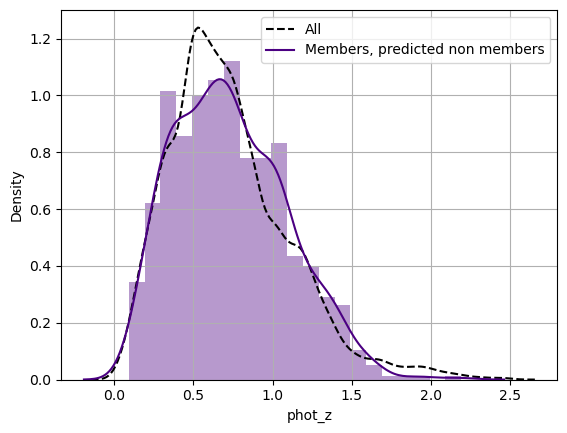

In [10]:
# true members, predicted as non members
mn = data.testing[(data.testing['member'] == 1) & (data.testing['member'] != test.predictions.flatten())]
sns.histplot(data = mn, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = mn, x = 'phot_z', label = 'Members, predicted non members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()

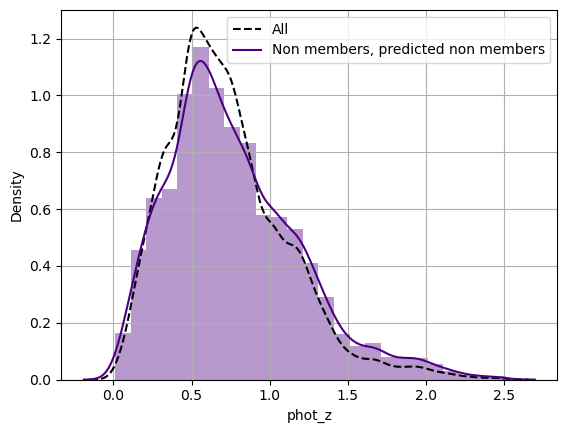

In [11]:
# true non members, predicted as non members
nn = data.testing[(data.testing['member'] == 0) & (data.testing['member'] == test.predictions.flatten())]
sns.histplot(data = nn, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = nn, x = 'phot_z', label = 'Non members, predicted non members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()


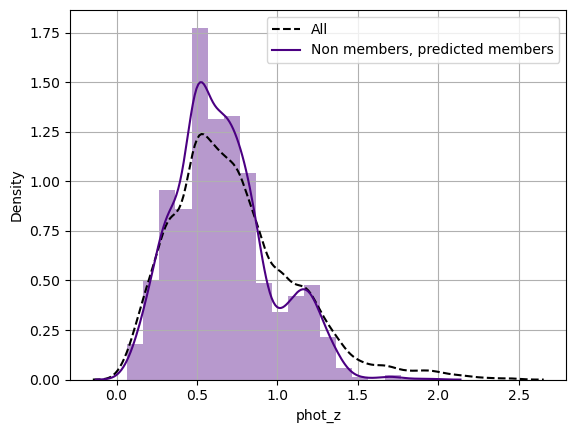

In [12]:
# true non members, predicted as members
nm = data.testing[(data.testing['member'] == 0) & (data.testing['member'] != test.predictions.flatten())]
sns.histplot(data = nm, x = 'phot_z', binwidth=0.1, common_norm = True, stat = 'density', element = 'step', fill = True, alpha = 0.4, edgecolor = None, color = 'indigo')
sns.kdeplot(data = data.testing, x = 'phot_z', label = 'All', common_norm= True, color = 'black', linestyle = '--')
sns.kdeplot(data = nm, x = 'phot_z', label = 'Non members, predicted members', common_norm= True, color = 'indigo')
plt.legend()
plt.grid()


### Fraction of correct/incorrect classification vs redshift

In [13]:
# true members, predicted as members
mm = data.testing[(data.testing['member'] == 1) & (data.testing['member'] == test.predictions.flatten())]
# true members, predicted as non members
mn = data.testing[(data.testing['member'] == 1) & (data.testing['member'] != test.predictions.flatten())]
# members
m = data.testing[(data.testing['member'] == 1)]

# true non members, predicted as non members
nn = data.testing[(data.testing['member'] == 0) & (data.testing['member'] == test.predictions.flatten())]
# true non members, predicted as members
nm = data.testing[(data.testing['member'] == 0) & (data.testing['member'] != test.predictions.flatten())]
# non members
n = data.testing[(data.testing['member'] == 0)]

In [14]:
# divide in bins of redshift, and get the fraction of members correctly and incorrectly classifies in each bin
corr_mem = []
incorr_mem = []
mem = []
corr_non = []
incorr_non = []
non = []

z_lims = np.linspace(0.0,1.8,10)
step = 0.2

df_list = [mm,mn,m,nn,nm,n]
count_list = [corr_mem, incorr_mem, mem, corr_non, incorr_non, non]

for i in z_lims:
    for df,count in zip(df_list, count_list):
        zbin = df[(df.phot_z >= i) & (df.phot_z < i+step)]
        count.append(zbin.shape[0] )

corr_mem = np.array(corr_mem)
incorr_mem = np.array(incorr_mem)
mem = np.array(mem)
corr_non = np.array(corr_non)
incorr_non = np.array(incorr_non)
non = np.array(non)

names = [f'[{i :.1f};{i+step :.1f}]' for  i in z_lims]


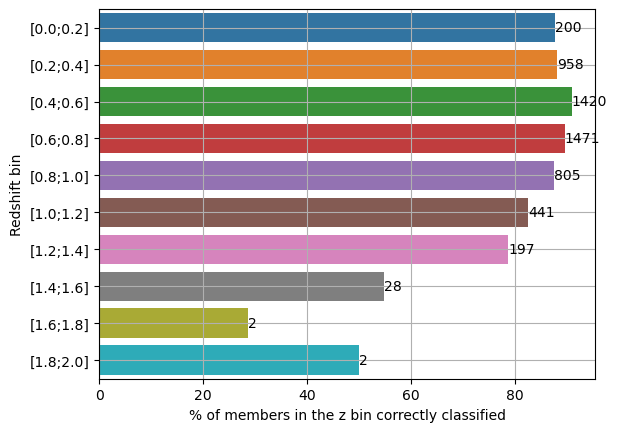

In [15]:
ax = sns.barplot(x = corr_mem/mem * 100, y = names, orient= 'h')
plt.xlabel('% of members in the z bin correctly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=corr_mem)
plt.show()

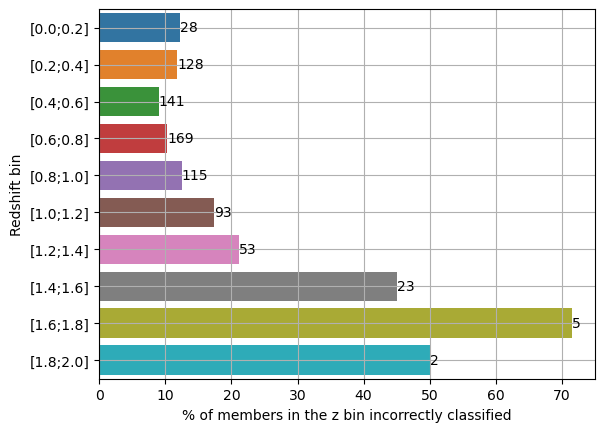

In [16]:
ax = sns.barplot(x = incorr_mem/mem*100, y = names, orient= 'h')
plt.xlabel('% of members in the z bin incorrectly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=incorr_mem)
plt.show()


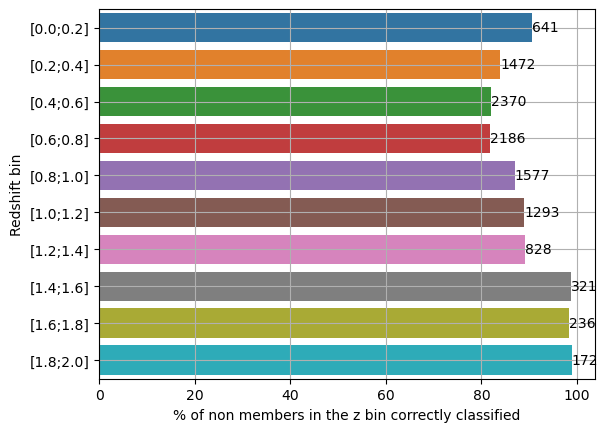

In [17]:
ax = sns.barplot(x = corr_non/non*100, y = names, orient= 'h')
plt.xlabel('% of non members in the z bin correctly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=corr_non)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

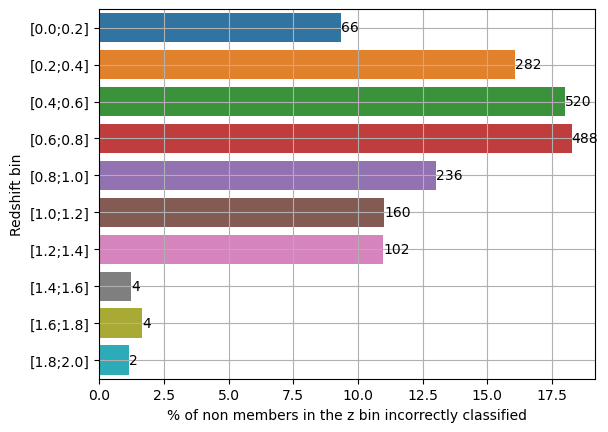

In [18]:
ax = sns.barplot(x = incorr_non/non*100, y = names, orient= 'h')
plt.xlabel('% of non members in the z bin incorrectly classified')
plt.ylabel('Redshift bin')
plt.grid()
ax.bar_label(ax.containers[0], labels=incorr_non)
plt.show

### Metrics vs redshift

In [19]:
min_ = 0.
max_ = 2.
step = 0.2
n_bins = int((max_ - min_)/step)
z_centers = np.linspace(min_ + step/2., max_ - step/2., n_bins)
z_lims = np.linspace(min_, max_, n_bins + 1)

print(z_centers)
print(z_lims)

[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


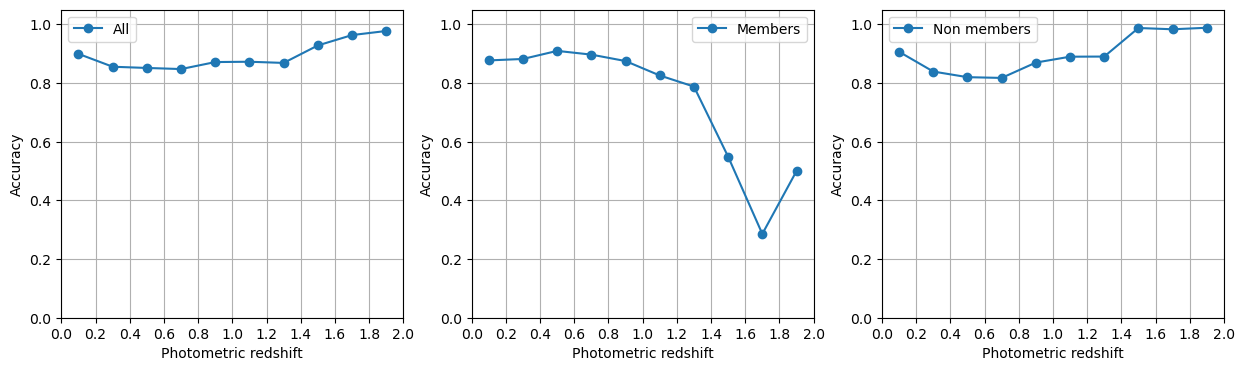

In [21]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
metric = sk.metrics.accuracy_score
met, met_mem, met_non = ([] for i in range(3))
for z in z_centers:
    cond = (data.testing['phot_z'] > z - step/2.) & (data.testing['phot_z'] <= z + step/2.)
    met.append(metric(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    cond = (data.testing['phot_z'] > z - step/2.) & (data.testing['phot_z'] <= z + step/2.) & (data.testing['member'] == 1)
    met_mem.append(metric(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    cond = (data.testing['phot_z'] > z - step/2.) & (data.testing['phot_z'] <= z + step/2.) & (data.testing['member'] == 0)
    met_non.append(metric(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

plt.figure(figsize=(15,4))
labels = ['All', 'Members', 'Non members']
for i,(a,l) in enumerate(zip([met, met_mem, met_non], labels)):
    plt.subplot(1,3,i+1)
    plt.plot(z_centers, a, label = l, marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Photometric redshift')
    plt.ylabel('Accuracy')
    plt.ylim(0,1.05)
    plt.xticks(z_lims)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


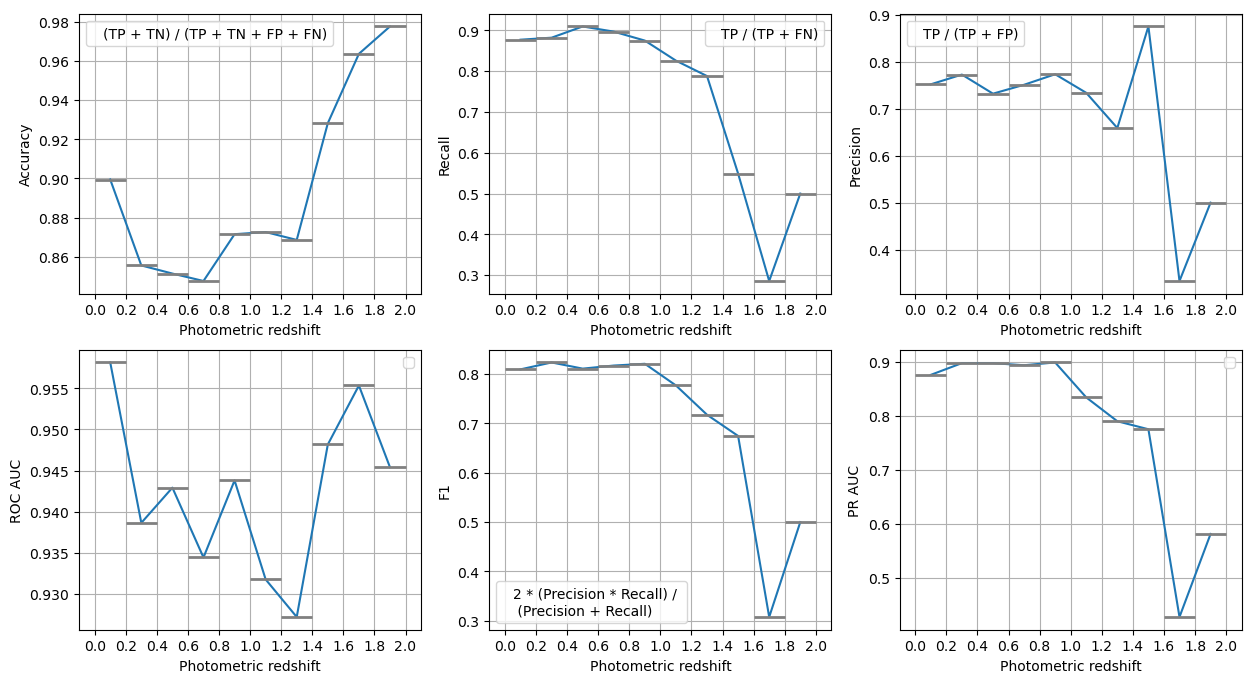

In [22]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
metrics = [sk.metrics.accuracy_score, sk.metrics.recall_score, sk.metrics.precision_score, sk.metrics.roc_auc_score, sk.metrics.f1_score, sk.metrics.average_precision_score]
names = ['Accuracy', 'Recall', 'Precision', 'ROC AUC', 'F1', 'PR AUC']
defs = [
    '(TP + TN) / (TP + TN + FP + FN)',
    'TP / (TP + FN)',
    'TP / (TP + FP)',
    '',
    '2 * (Precision * Recall) / \n (Precision + Recall)',
    ''
]

plt.figure(figsize=(15,8))
z_metrics = [[] for i in metrics]

for i,(met,zmet,nam,d) in enumerate(zip(metrics, z_metrics, names, defs)):
    for z in z_centers:
        cond = (data.testing['phot_z'] > z - step/2) & (data.testing['phot_z'] <= z + step/2)
        if (nam == 'ROC AUC') | (nam == 'PR AUC'):
            zmet.append(met(y_true= data.testing_labels()[cond], y_score= test.scores[cond]))
        else:
            zmet.append(met(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    plt.subplot(2,3,i+1)
    plt.plot(z_centers, zmet, label = d)
    plt.grid()
    plt.xlabel('Photometric redshift')
    plt.ylabel(nam)
    plt.legend(markerscale=0, handlelength=0)
    plt.xticks(z_lims)

    for i, z in enumerate(z_centers):
        plt.hlines(zmet[i], z - step/2, z + step/2, color='grey', linewidth=2)
plt.show()

In [ ]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
metrics = [sk.metrics.recall_score, sk.metrics.precision_score, sk.metrics.roc_auc_score]
names = ['Recall (Completitud)', 'Precision (Pureza)', 'ROC AUC']
defs = [
    'TP / (TP + FN)',
    'TP / (TP + FP)',
    ''
]

plt.figure(figsize=(7.5,2.3), dpi = 500)
pal = sns.color_palette("Set2")
sns.set_palette(pal, color_codes=True)
z_metrics = [[] for i in metrics]

for i,(met,zmet,nam,d) in enumerate(zip(metrics, z_metrics, names, defs)):
    for z in z_centers:
        cond = (data.testing['phot_z'] > z - step/2) & (data.testing['phot_z'] <= z + step/2)
        if nam == 'ROC AUC':
            zmet.append(met(y_true= data.testing_labels()[cond], y_score= test.scores[cond]))
        else:
            zmet.append(met(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

    plt.subplot(1,3,i+1, facecolor = (1, 1, 1, 0.6))
    plt.plot(z_centers, zmet, label = d, lw=4, c = 'black')
    plt.grid(ls = '--', alpha=0.25, c = 'black')
    plt.xlabel('Redshift fotométrico')
    plt.ylabel(nam)
    if d:
        legend = plt.legend(edgecolor=(0, 0, 0, 1.), markerscale=0, handlelength=0)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0))
    plt.xticks([0.4,0.8,1.2,1.6])
    # plt.axes(frame_on=False)
    sns.despine(left=True, bottom=True, right=True)

    # for i, z in enumerate(z_centers):
    #     plt.hlines(zmet[i], z - step/2, z + step/2, color='grey', linewidth=2)
plt.tight_layout()
plt.savefig('demo.png', facecolor=(1,1,1,0))
plt.close()


c:\Users\Gimena\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Metrics vs features

In [67]:
features = ['ri', 'W1i', 'iz', 'i_cmodel_mag', 'W1', 'r_cmodel_mag', 'i_cmodel_mag_abs', 'r_cmodel_mag_abs', 'phot_z', 'log_st_mass', 'phot_z_cl_y', 'r500_cl_y','mass_cl_y','n500_cl_y']
df_cl =pd.read_table('../../DATA/scripts/Wen+Han/clusters.dat', delim_whitespace=True, usecols=[0,3,4,5,9,11,12], names=['id_cl_near','ra_cl','dec_cl','phot_z_cl', 'r500_cl','mass_cl','n500_cl'])

In [70]:
df = data.testing.join(df_cl, on= 'id_cl_near', how = 'left', rsuffix='_y')

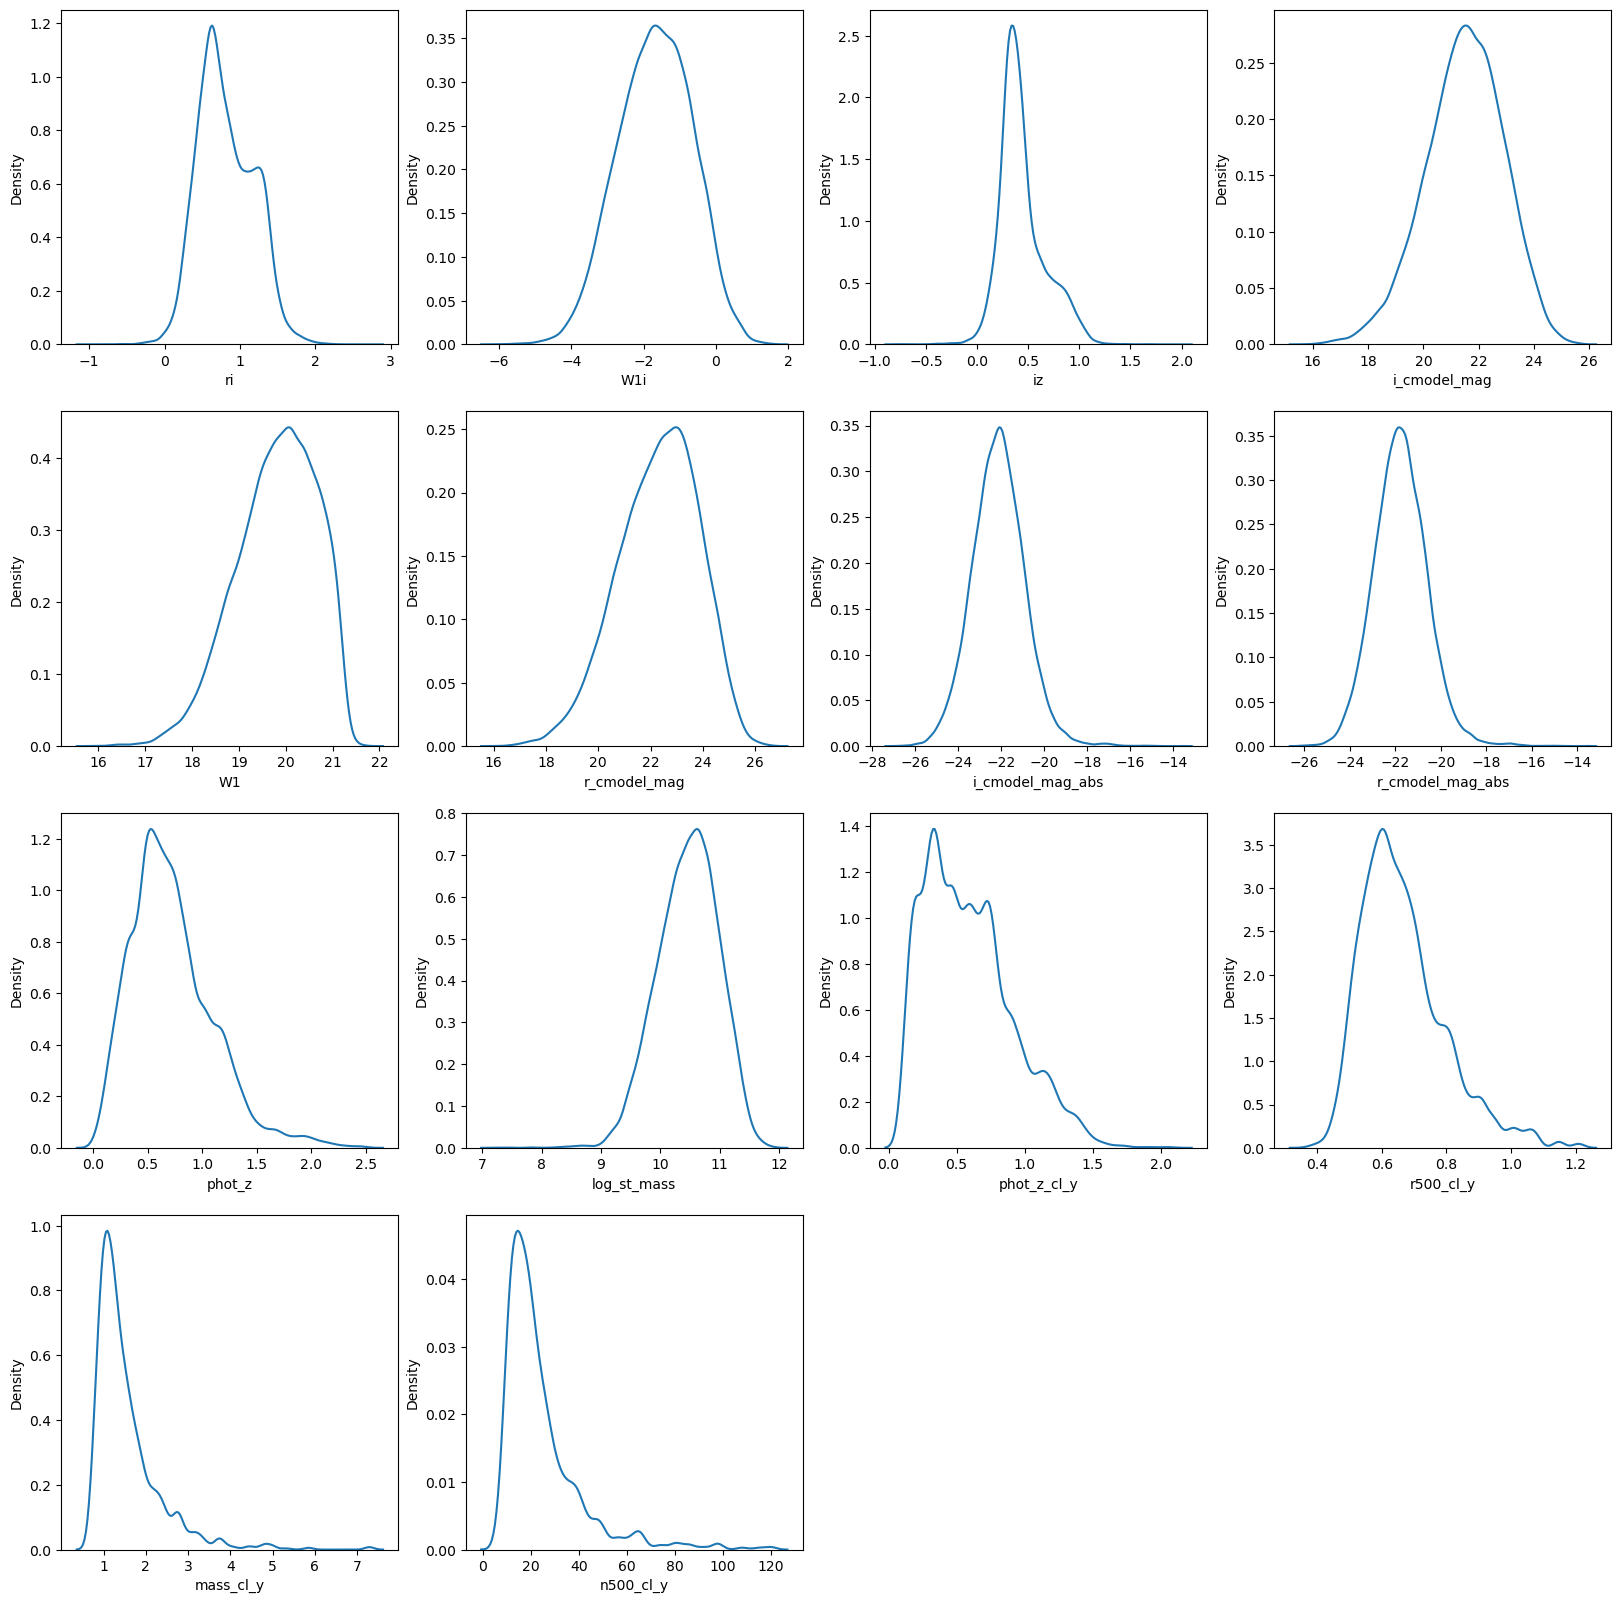

In [60]:
plt.figure( figsize= (20, 20))
j = 1
for f in features:
    plt.subplot(4,4,j)
    sns.kdeplot(data = df, x = f)
    j+=1

In [72]:
metrics = [sk.metrics.accuracy_score, sk.metrics.recall_score, sk.metrics.precision_score, sk.metrics.roc_auc_score, sk.metrics.f1_score, sk.metrics.average_precision_score]
names = ['Accuracy', 'Recall', 'Precision', 'ROC AUC', 'F1', 'PR AUC']
defs = [
        '(TP + TN) / (TP + TN + FP + FN)',
        'TP / (TP + FN)',
        'TP / (TP + FP)',
        '',
        '2 * (Precision * Recall) / \n (Precision + Recall)',
        ''
    ]

def func(feature, min_, max_, step):
    n_bins = int((max_ - min_)/step)
    centers = np.linspace(min_ + step/2., max_ - step/2., n_bins)
    lims = np.linspace(min_, max_, n_bins + 1) 
    
    plt.figure(figsize=(15,8))
    f_metrics = [[] for i in metrics]

    for i,(met,fmet,nam,d) in enumerate(zip(metrics, f_metrics, names, defs)):
        for z in centers:
            cond = (df[feature] > z - step/2) & (df[feature] <= z + step/2)
            if (nam == 'ROC AUC') | (nam == 'PR AUC'):
                fmet.append(met(y_true= data.testing_labels()[cond], y_score= test.scores[cond]))
            else:
                fmet.append(met(y_true= data.testing_labels()[cond], y_pred= test.predictions[cond]))

        plt.subplot(2,3,i+1)
        plt.plot(centers, fmet, label = d)
        plt.grid()
        plt.xlabel(feature)
        plt.ylabel(nam)
        plt.legend(markerscale=0, handlelength=0)
        plt.xticks(lims)

        for i, z in enumerate(centers):
            plt.hlines(fmet[i], z - step/2, z + step/2, color='grey', linewidth=2)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


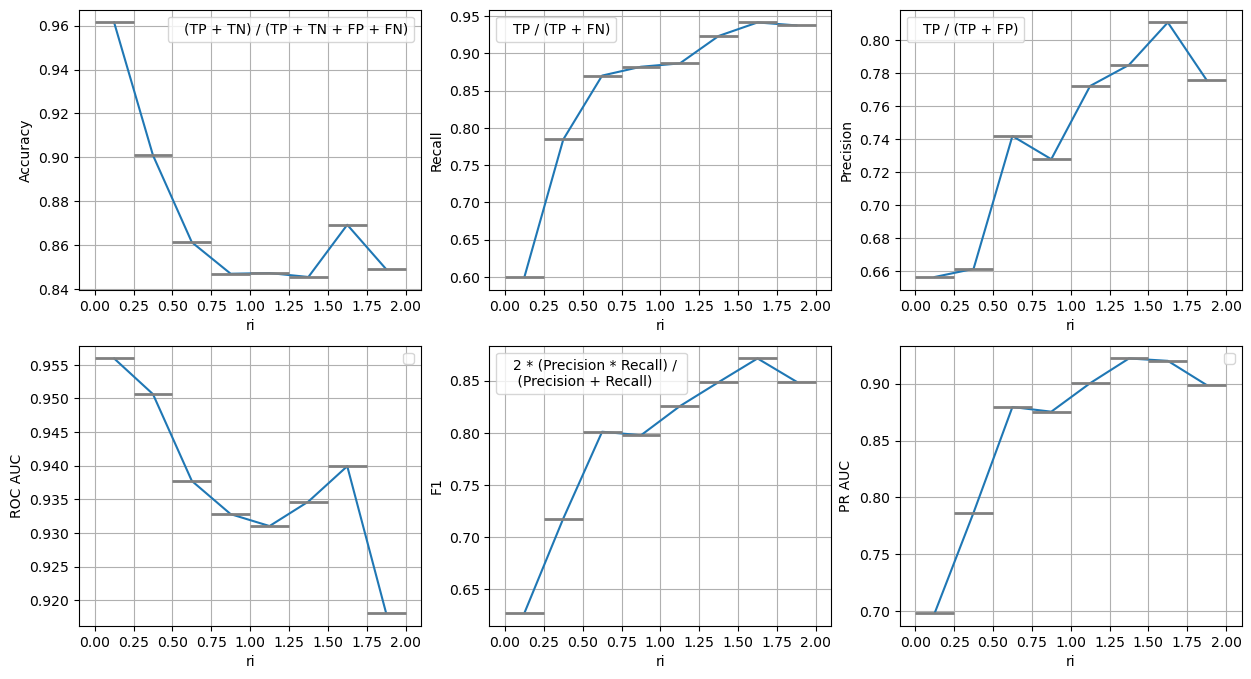

In [20]:
func('ri', 0. , 2., 0.25)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


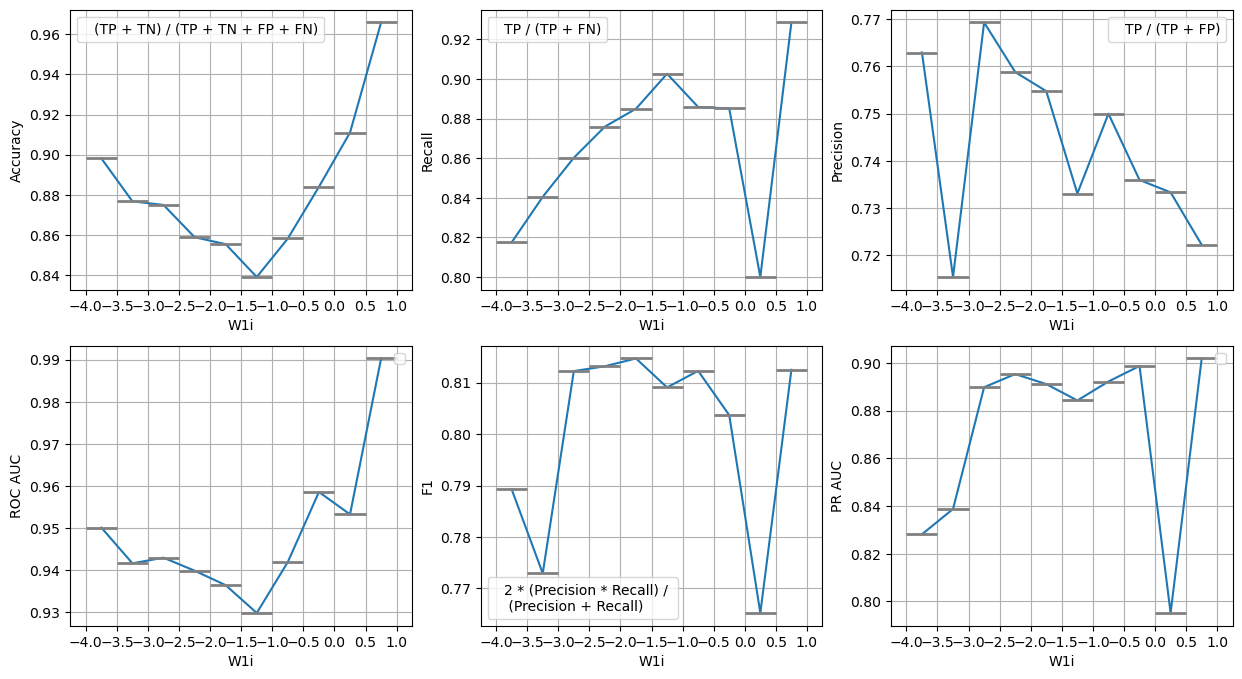

In [22]:
func('W1i', -4. , 1., 0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


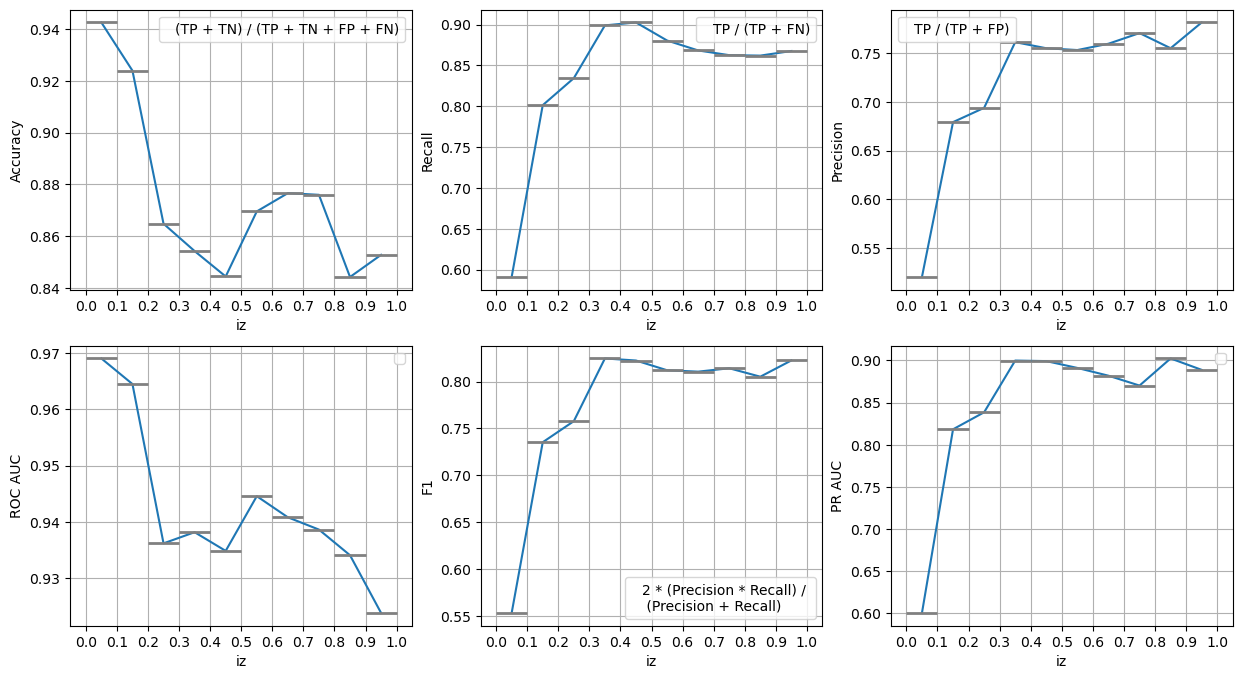

In [23]:
func('iz', 00. , 1., 0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


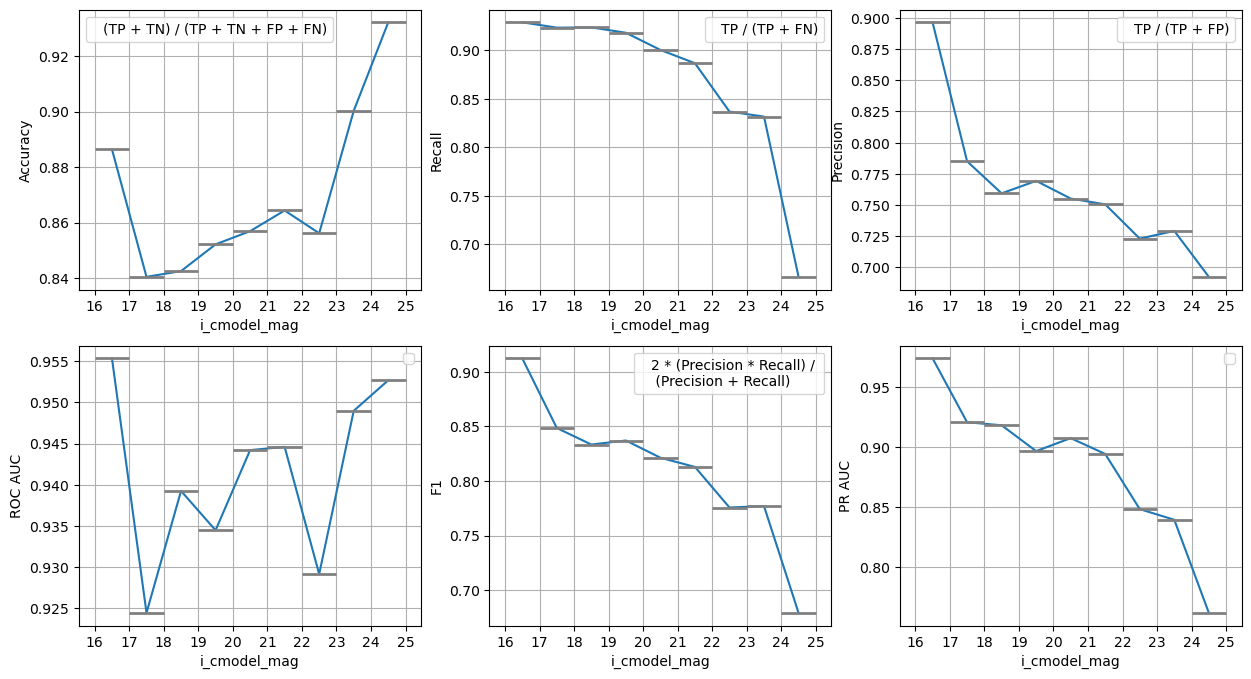

In [24]:
func('i_cmodel_mag', 16. , 25., 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


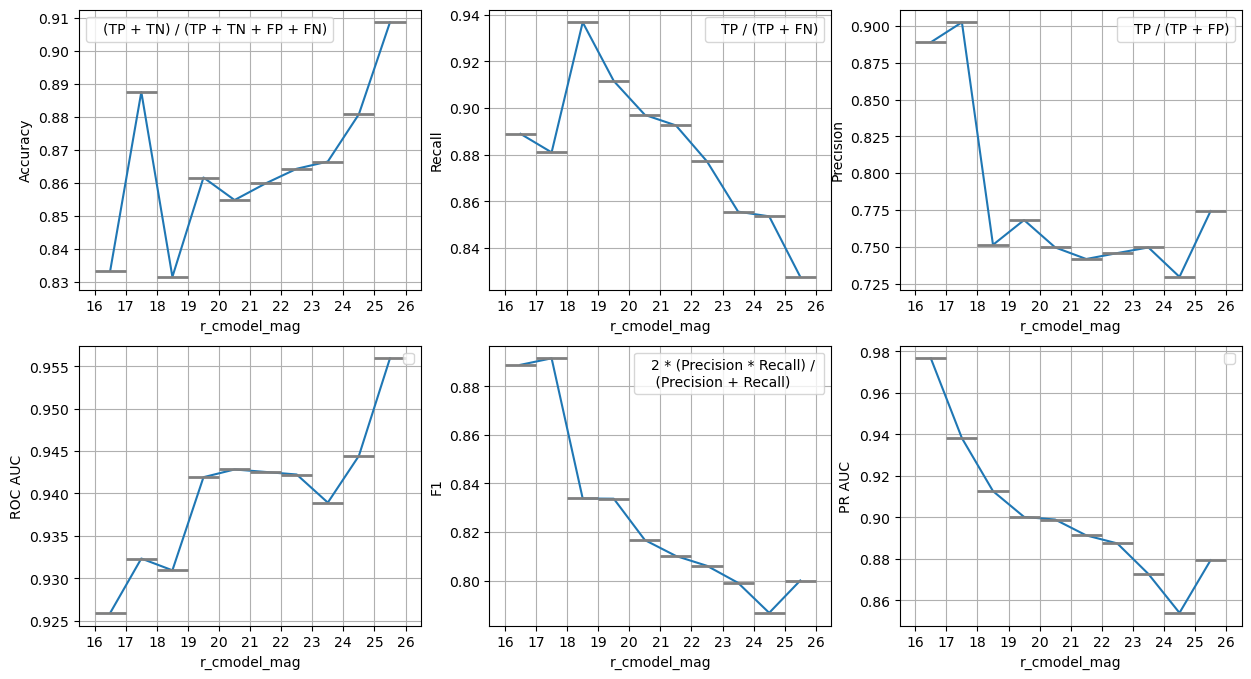

In [25]:
func('r_cmodel_mag', 16. , 26., 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


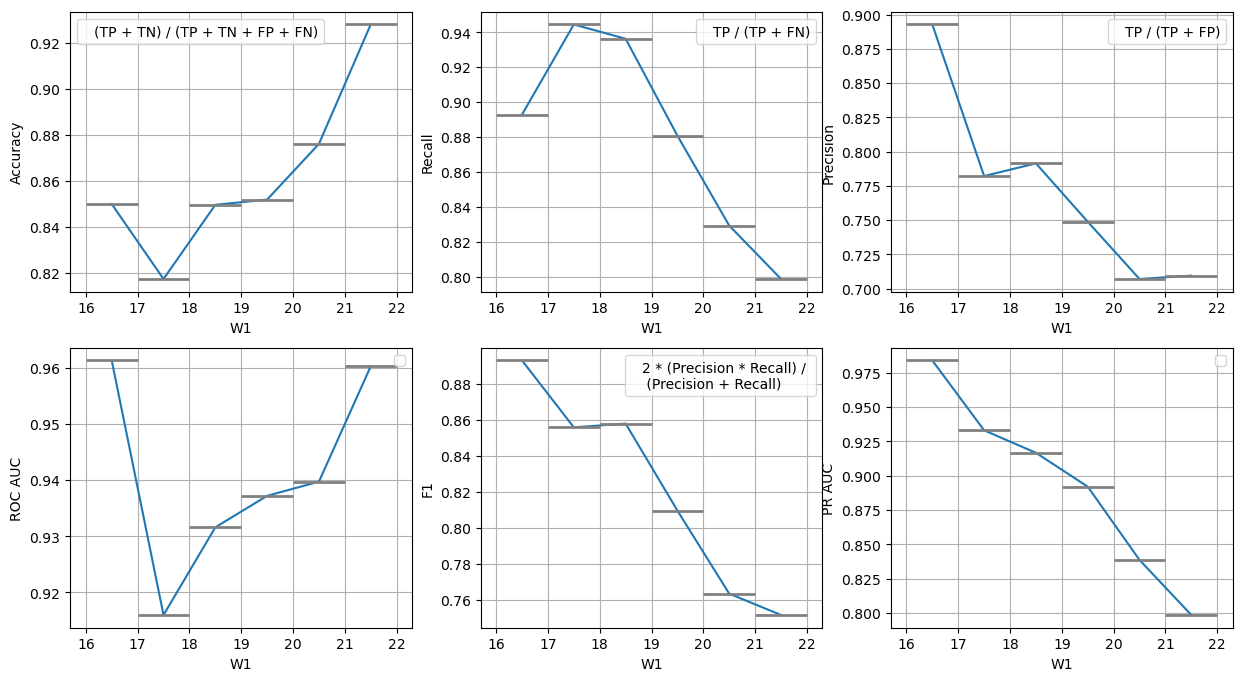

In [26]:
func('W1', 16. , 22., 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


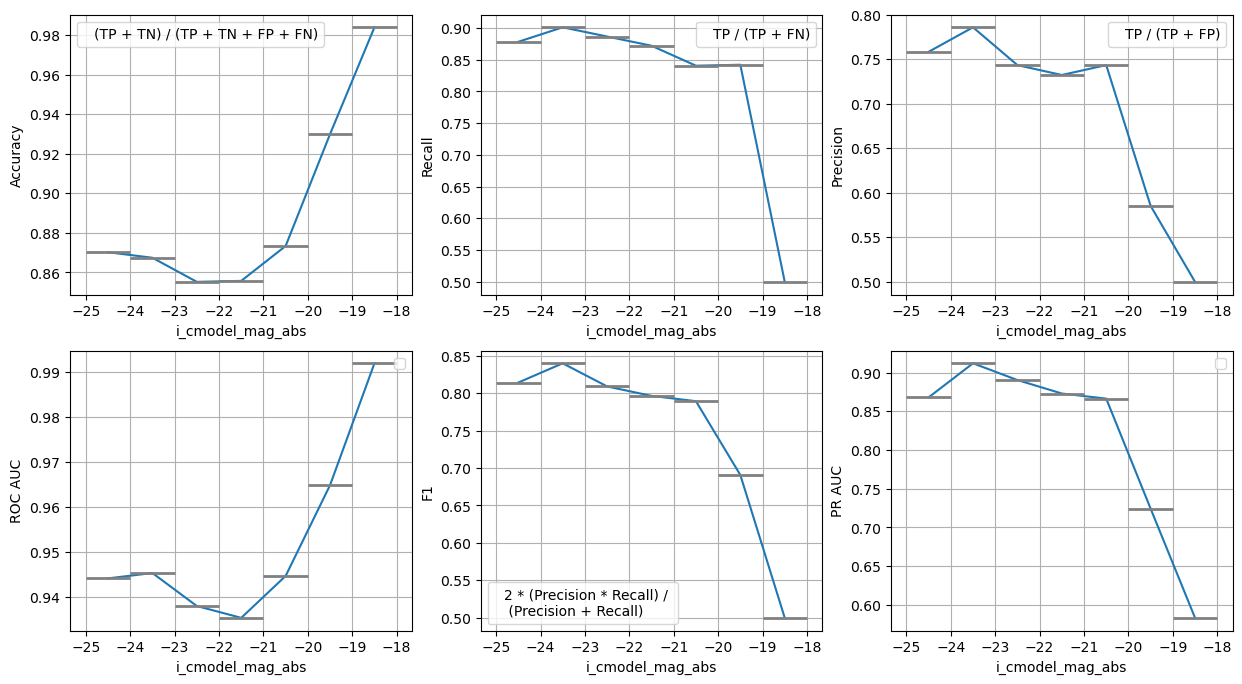

In [34]:
func('i_cmodel_mag_abs', -25. , -18., 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


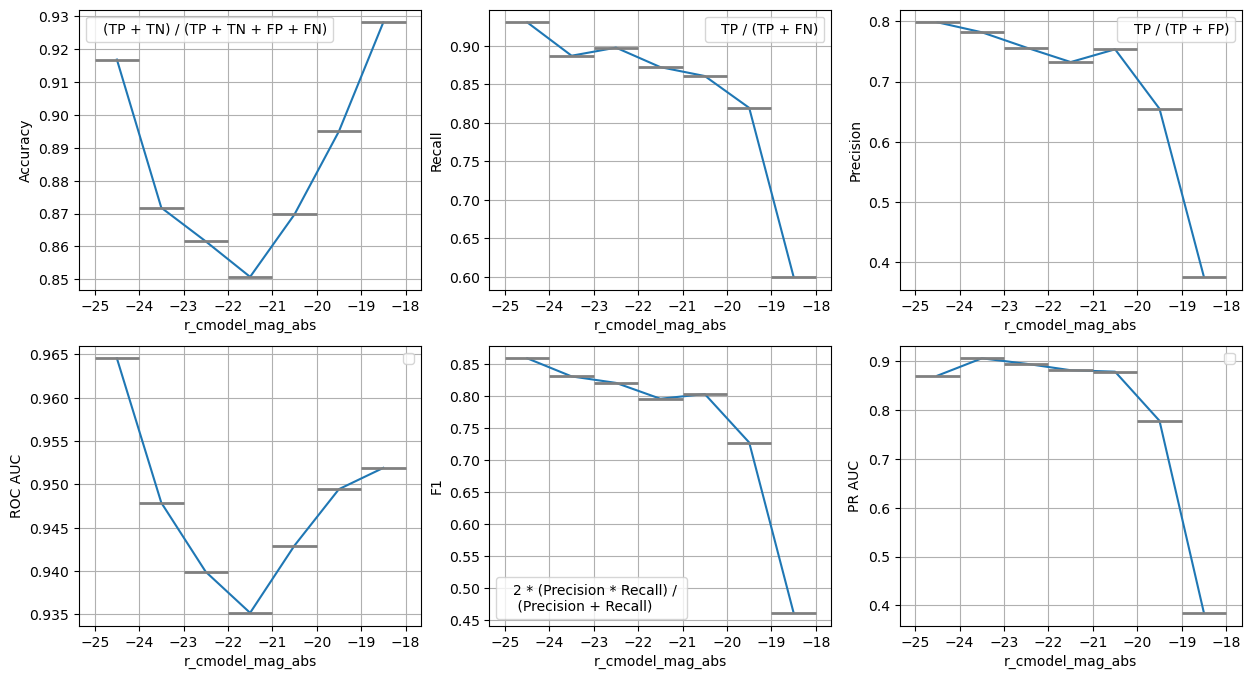

In [35]:
func('r_cmodel_mag_abs', -25. , -18., 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


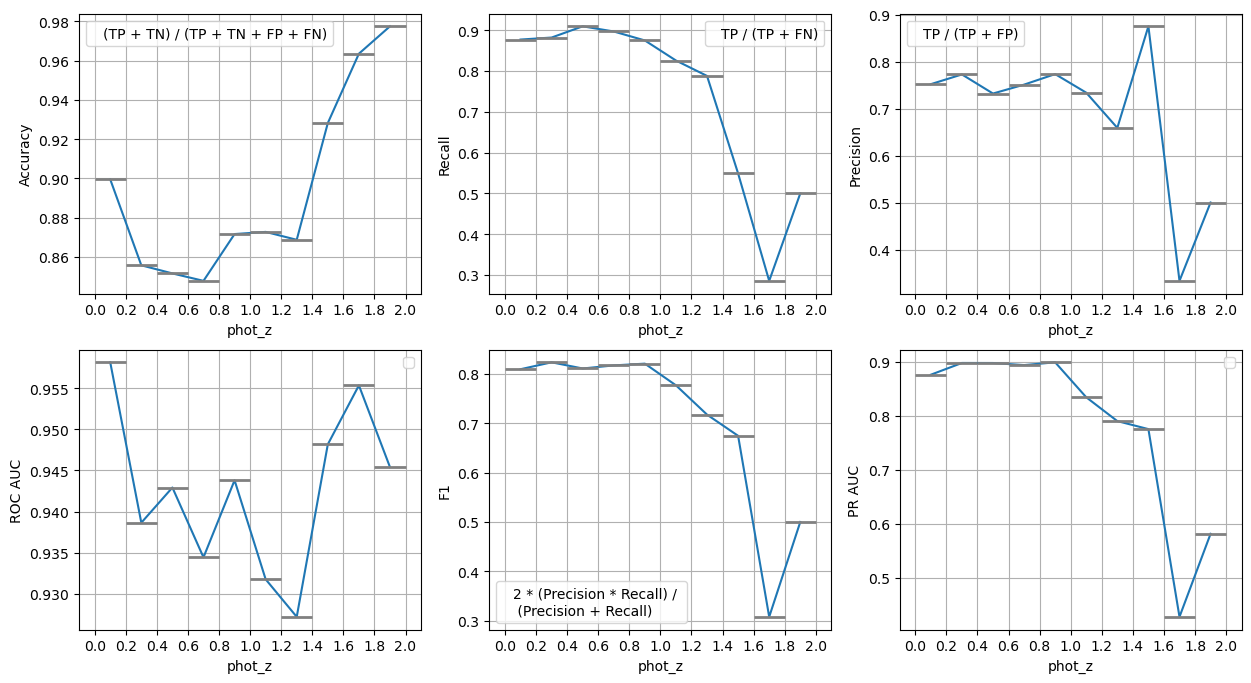

In [38]:
func('phot_z', 0. , 2, 0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


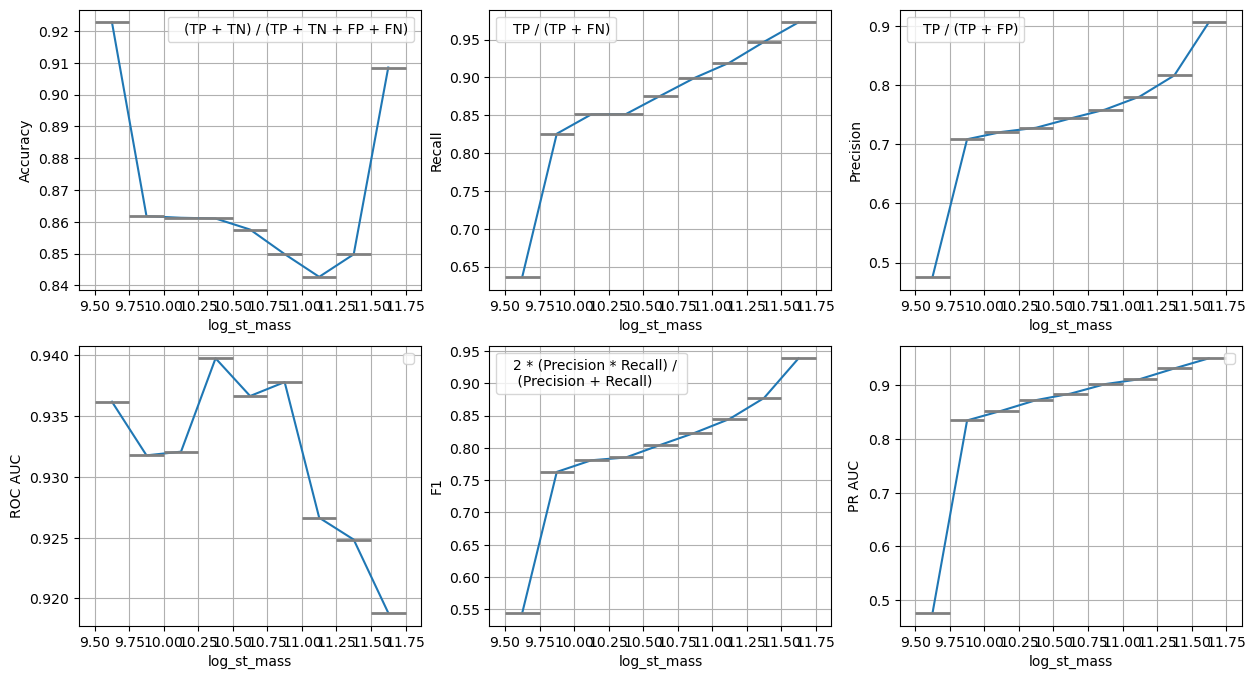

In [73]:
func('log_st_mass', 9.5 , 11.75, 0.25)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


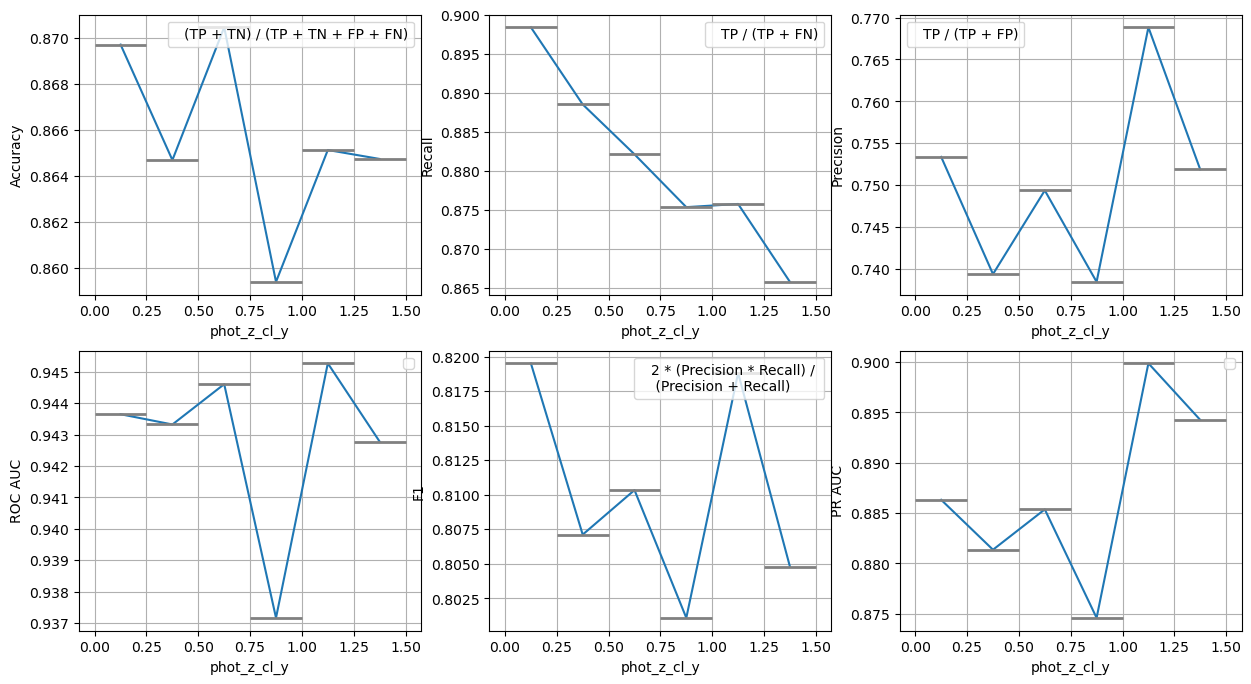

In [74]:
func('phot_z_cl_y', 0. , 1.5, 0.25)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


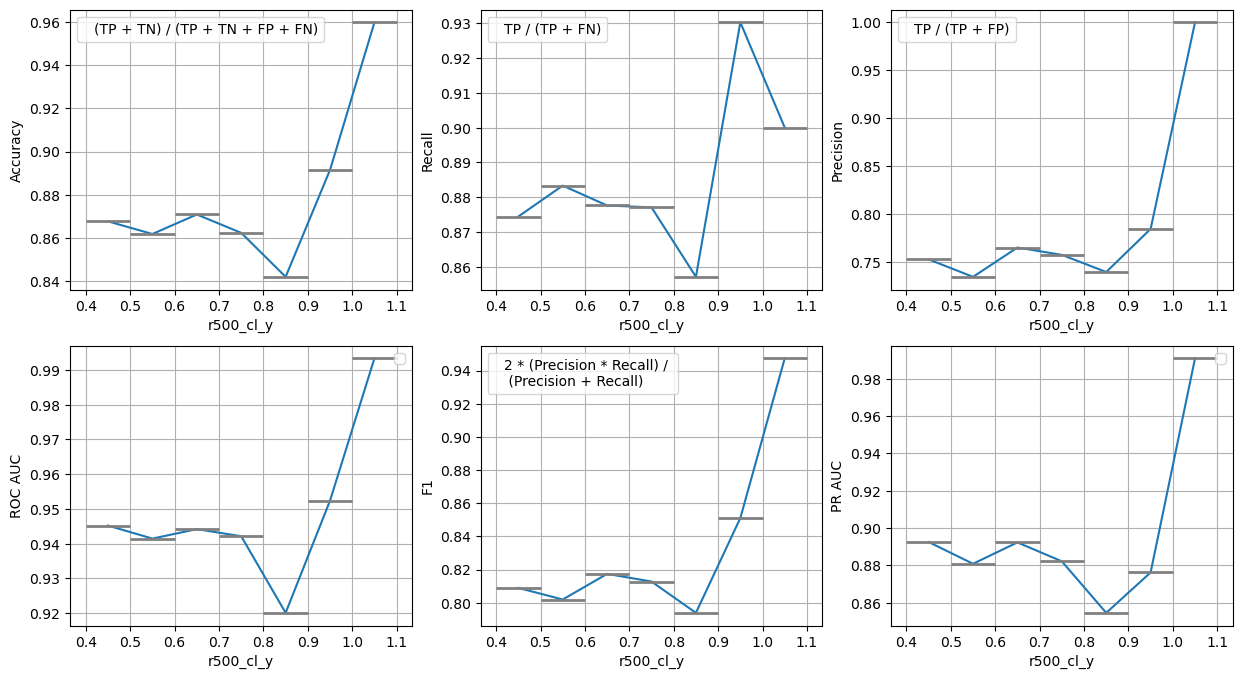

In [78]:
func('r500_cl_y', 0.4 , 1.1, 0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


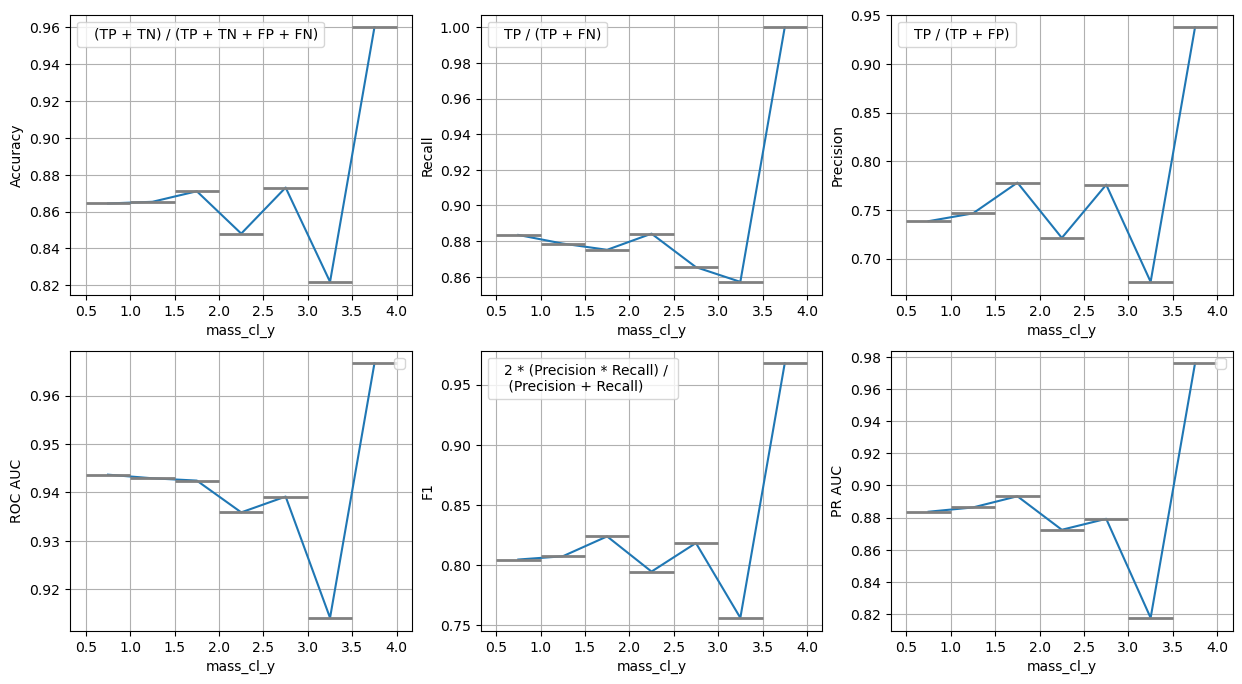

In [81]:
func('mass_cl_y', 0.5 , 4, 0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


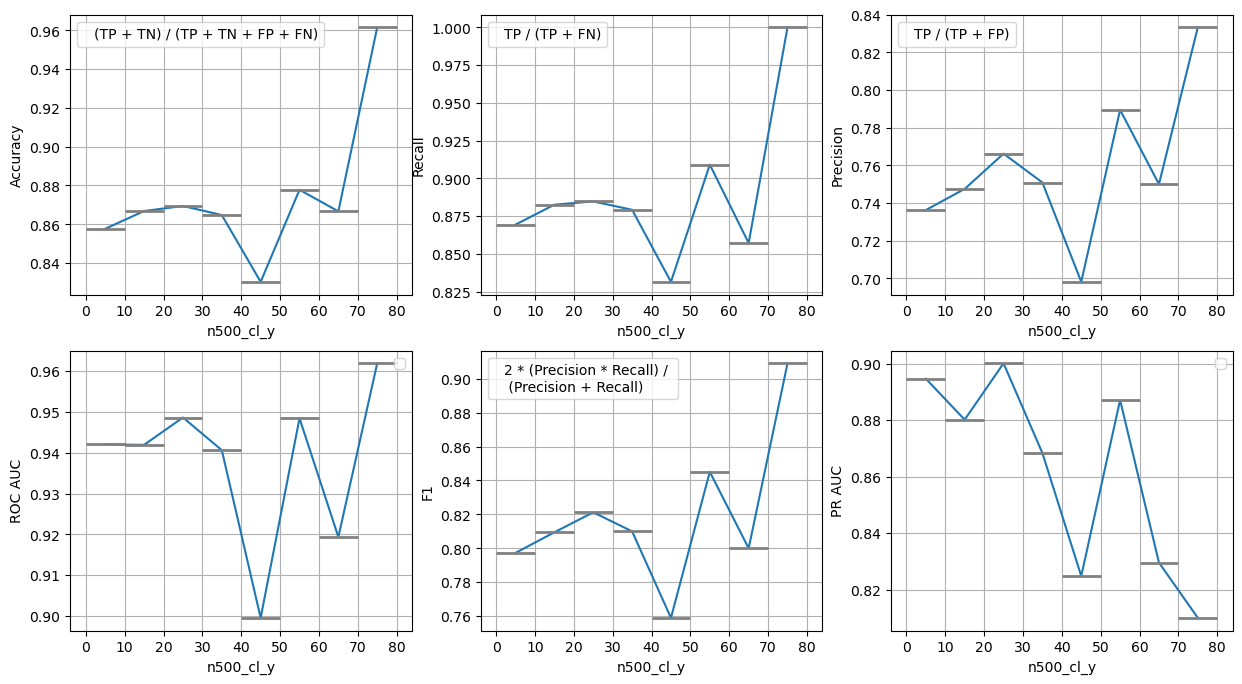

In [82]:
func('n500_cl_y', 0 , 80, 10)